# White Male Effect Analysis
### Ekim Luo
*last updated September 7, 2021*
- All data files were cleaned and scored in Python. 
- This file contains data analysis.

### Data for perceived COVID-19 mortality risks
- [Understanding America Study](https://uasdata.usc.edu/index.php) (UAS) COVID-19 National Survey Data, Center for Economic and Social Research, University of Southern California
    - Original data: March 10, 2020 - June 22, 2021 (28 waves)
    - My data: April 1, 2020 - June 22, 2021 (27 waves)

If downloading data in the `.dta` (Stata) format, you can convert it into a `csv` file using the `haven` package in R:

```r
# if haven isn't installed, run 
# install.packages('haven')
library(haven)
df <- read_dta('filePath')
write.csv(df, file = 'df.csv', row.names = False)
```

### Data for recorded COVID-19 mortality
- [COVID-19 Case Surveillance Public Use Data](https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf), CDC
    - January 1, 2020 - July 7, 2021

## Setting up

In [1]:
# version check
R.version

               _                           
platform       x86_64-conda_cos6-linux-gnu 
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          6.1                         
year           2019                        
month          07                          
day            05                          
svn rev        76782                       
language       R                           
version.string R version 3.6.1 (2019-07-05)
nickname       Action of the Toes          

In [2]:
# load packages
library(dplyr)
library(Rmisc)
library(car)
library(effects)
library(dunn.test)
library(lmerTest)
library(ggplot2) # required for loading waffle
library(waffle)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice
Loading required package: plyr
------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

Warning message:
“package ‘effects’ was built under R version 3.6.3”Registered S3 methods overwritten b

In [3]:
# import cleaned data
# data were cleaned and scored in Python
uas_full <- read.csv('uas_cleaned_full.csv') # this DataFrame contains all participants regardless of how many waves they participated in
uas_more <- read.csv('uas_morethan1wave.csv') # this DataFrame contains participants who responded to more than 1 wave
uas_only <- read.csv('uas_only1wave.csv') # this DataFrame contains participants who only responded to one wave

In [4]:
# preview data
head(uas_full)

X,uasid,uashhid,survhhid,wave,survey_source,uasmembers,final_weight,sampletype,primary_respondent,...,vc005c,vd001,vd002,vd003,vd004,cs_001,group,group2,race2,boolean
6932,140100007,140100007,.n,2,235,0,2.7013082,1,1,...,NA,NA,NA,NA,NA,1,wm,1,1,False
6933,140100035,140100035,.n,2,235,0,0.9632072,1,1,...,NA,NA,NA,NA,NA,3,wm,1,1,False
6934,140100038,140100038,.n,2,235,0,2.8756938,1,1,...,NA,NA,NA,NA,NA,2,wm,1,1,False
6935,140100041,140100041,560400799,2,235,1,1.0150338,1,1,...,NA,NA,NA,NA,NA,3,wm,1,1,False
6936,140100047,140100047,.n,2,235,0,0.6924597,1,1,...,NA,NA,NA,NA,NA,2,ww,0,1,False
6937,140100048,140100048,560404728,2,235,1,1.9609891,1,1,...,NA,NA,NA,NA,NA,1,ww,0,1,False


## Plotting data

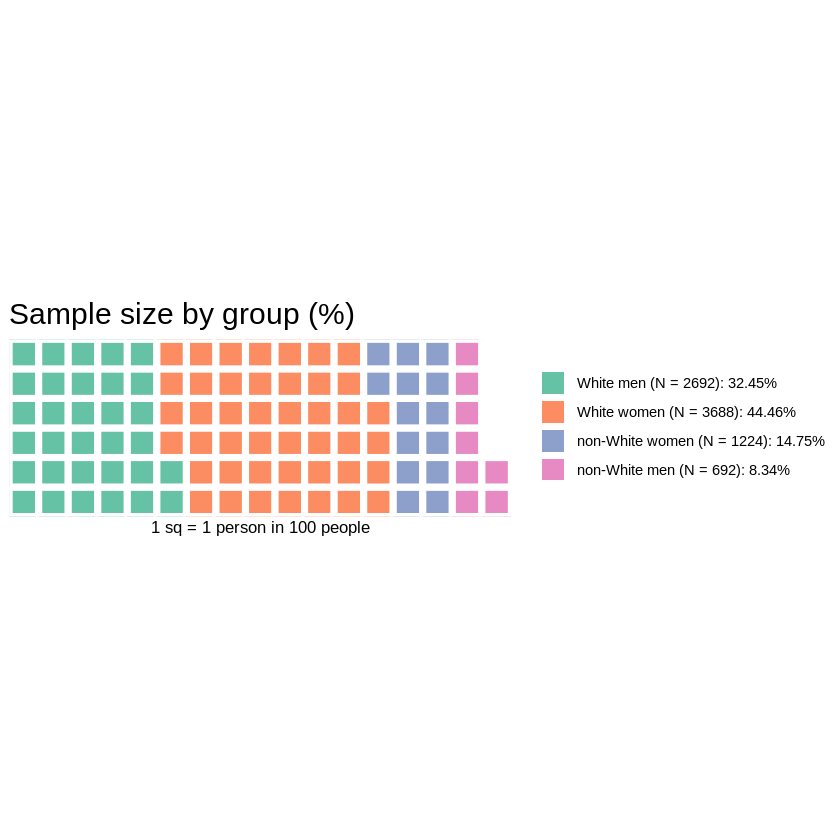

In [5]:
# waffle plot for sample N by group
sample_group <- c('White men (N = 2692): 32.45%' = 2692*100/8296, 
                  'White women (N = 3688): 44.46%' = 3688*100/8296, 
                  'non-White women (N = 1224): 14.75%' = 1224*100/8296, 
                  'non-White men (N = 692): 8.34%' = 692*100/8296)
waffle(sample_group, 
       title = 'Sample size by group (%)',
       xlab = '1 sq = 1 person in 100 people',
       rows = 6)

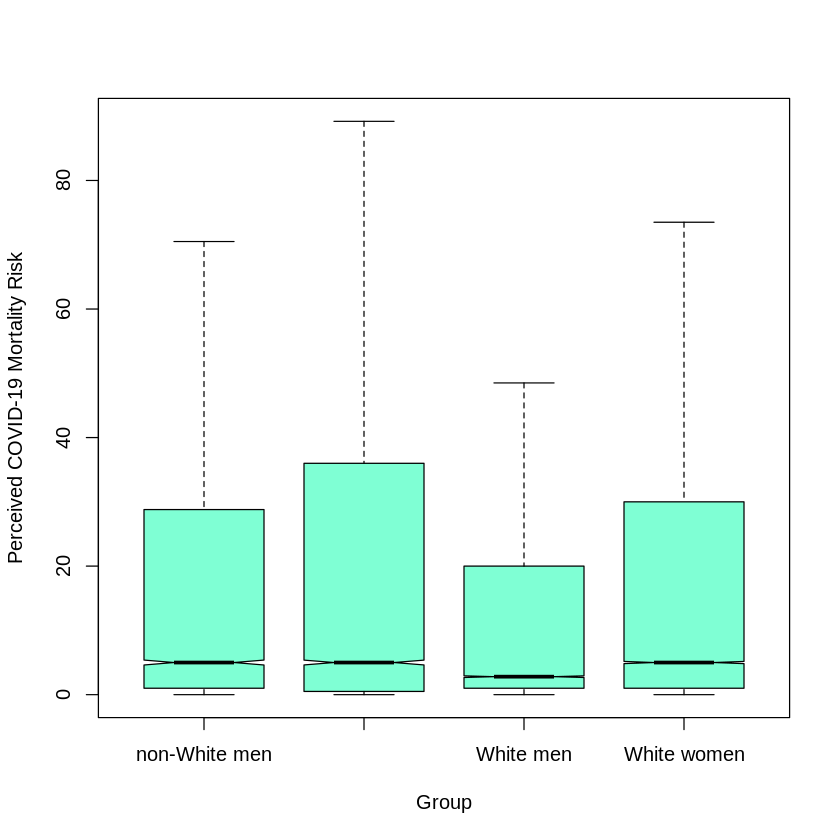

In [6]:
# boxplot by group
boxplot(prisk_die ~ group, 
        xlab = 'Group',
        ylab = 'Perceived COVID-19 Mortality Risk',
        outline = FALSE, # omit showing outliers
        names = c('non-White men','non-White women','White men','White women'),
        notch = TRUE,
        col = 'aquamarine',
        boxwex = 0.75, # scale boxes
        data = uas_full)

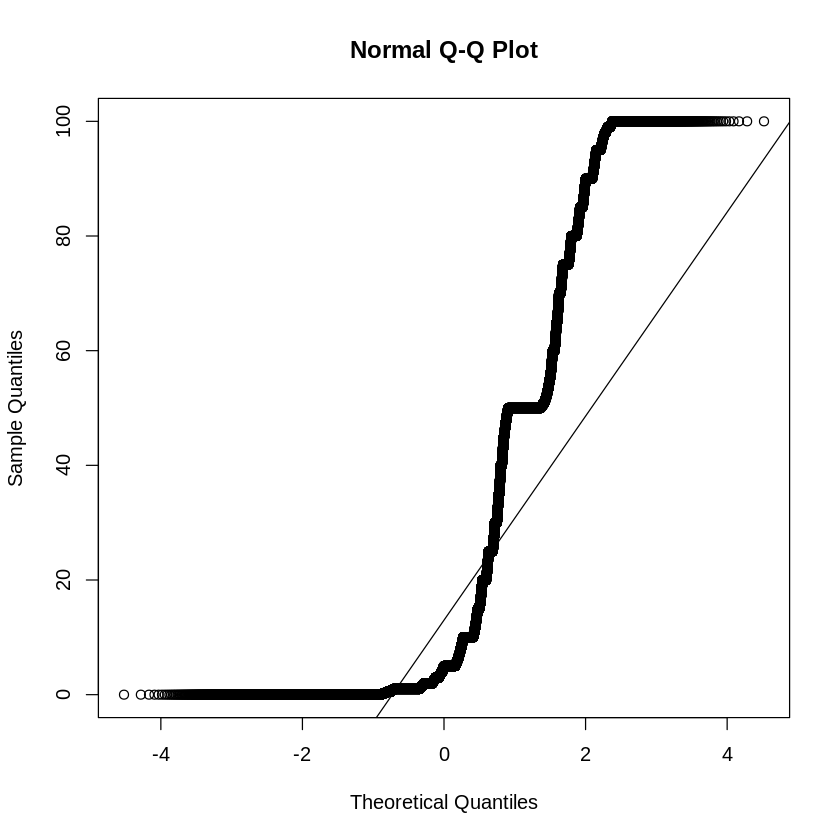

In [7]:
# check assumption of normality
# DV is not normal, but sample N = 8127, so parametric tests should still be robust
qqnorm(uas_full$prisk_die)
qqline(uas_full$prisk_die)

## One-way Repeated Measures ANCOVA

### *Does perceived risk of COVID-19 mortality differ between groups?*

**Equation:** perceived risk of COVID-19 mortality = group + household income + age + education + hospitalized how many family or close friends + died how many family or close friends + N days in the past seven worked from home + household size + (1|wave) + (1|uasid)

In [8]:
# one-way repeated measures ANCOVA with random effects 
# main predictor (group) has 4 levels
aov_group <- aov(prisk_die ~ group + hhincome + age + education + cr022a + cr022b + jobs_dayswfh + hhmembernumber + (1|wave) + (1|uasid), uas_full)
summary(aov_group)

                  Df   Sum Sq Mean Sq  F value   Pr(>F)    
group              3   320195  106732  310.005  < 2e-16 ***
hhincome           1   887557  887557 2577.938  < 2e-16 ***
age                1   514972  514972 1495.752  < 2e-16 ***
education          1   285825  285825  830.186  < 2e-16 ***
cr022a             1    15391   15391   44.703 2.31e-11 ***
cr022b             1       26      26    0.076    0.783    
jobs_dayswfh       1    18717   18717   54.364 1.68e-13 ***
hhmembernumber     1      819     819    2.377    0.123    
Residuals      73491 25302195     344                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
90103 observations deleted due to missingness

In [9]:
# Tukey's post hoc
tukey_group <- aov(prisk_die ~ group, uas_full)
TukeyHSD(tukey_group)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = prisk_die ~ group, data = uas_full)

$group
            diff        lwr        upr     p adj
nw-nm  1.1499540  0.4657333  1.8341747 0.0000929
wm-nm -2.2388891 -2.8443596 -1.6334186 0.0000000
ww-nm  0.4654038 -0.1250322  1.0558398 0.1787111
wm-nw -3.3888431 -3.8832101 -2.8944761 0.0000000
ww-nw -0.6845502 -1.1603851 -0.2087153 0.0012537
ww-wm  2.7042929  2.3509440  3.0576417 0.0000000


In [10]:
# simple effect analysis
summary(effect('group', aov_group, se = TRUE))


 group effect
group
       nm        nw        wm        ww 
13.047529 15.318818  9.547718 11.670978 

 Lower 95 Percent Confidence Limits
group
       nm        nw        wm        ww 
12.592490 14.950989  9.315478 11.465430 

 Upper 95 Percent Confidence Limits
group
       nm        nw        wm        ww 
13.502569 15.686647  9.779958 11.876526 

In [11]:
# Kruskal Wallis to confirm results
kruskal.test(prisk_die ~ group, uas_full)


	Kruskal-Wallis rank sum test

data:  prisk_die by group
Kruskal-Wallis chi-squared = 624.9, df = 3, p-value < 2.2e-16


In [12]:
# dunn's test
# use altp argument to report true p-values
dunn.test(uas_full$prisk_die, uas_full$group, altp = TRUE)

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 624.8964, df = 3, p-value = 0


                           Comparison of x by group                            
                                (No adjustment)                                
Col Mean-|
Row Mean |         nm         nw         wm
---------+---------------------------------
      nw |  -0.719449
         |     0.4719
         |
      wm |   12.37406   16.15073
         |    0.0000*    0.0000*
         |
      ww |  -1.458596  -0.775364  -23.64047
         |     0.1447     0.4381    0.0000*

alpha = 0.05
Reject Ho if p <= alpha


## Two-way ANOVAs

### *Does race interact with gender to predict perceived risk perception of COVID-19 mortality?*

**Equation:** perceived risk of COVID-19 mortality = race2 x gender + household income + age + education + hospitalized how many family or close friends + died how many family or close friends + N days in the past seven worked from home + household size + (1|uasid) + (1|wave)

In [13]:
# two-way anova
# race x gender
lmm_twoway <- lmer(prisk_die ~ race2*gender + age + hhincome + education + cr022a + cr022b + jobs_dayswfh + hhmembernumber + (1|wave) + (1|uasid), uas_full)
anova(lmm_twoway)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00231329 (tol = 0.002, component 1)”

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
race2,930.2505748,930.2505748,1,6298.034,1.314965e+01,2.898458e-04
gender,571.2483033,571.2483033,1,6331.426,8.074938e+00,4.502509e-03
age,5487.1932748,5487.1932748,1,5581.870,7.756477e+01,1.689010e-18
hhincome,3329.5164768,3329.5164768,1,51618.319,4.706471e+01,6.945278e-12
education,8994.2348049,8994.2348049,1,6519.441,1.271389e+02,3.224871e-29
cr022a,3174.1147425,3174.1147425,1,69342.018,4.486802e+01,2.123752e-11
cr022b,655.7488749,655.7488749,1,69534.364,9.269404e+00,2.331006e-03
jobs_dayswfh,9.9383460,9.9383460,1,73184.416,1.404845e-01,7.078009e-01
hhmembernumber,0.2185357,0.2185357,1,34907.102,3.089133e-03,9.556767e-01
race2:gender,7.0103943,7.0103943,1,6884.628,9.909613e-02,7.529266e-01


### *Does time interact with group to predict perceived risk perception of COVID-19 mortality?*

**Equation:** perceived risk of COVID-19 mortality = wave x group2 + household income + age + education + hospitalized how many family or close friends + died how many family or close friends + N days in the past seven worked from home + household size + (1|uasid)

In [14]:
# two-way anova
# wave x group2
lmm_twoway_wave <- lmer(prisk_die ~ wave*group2 + age + hhincome + education + cr022a + cr022b + jobs_dayswfh + hhmembernumber + (1|uasid), uas_full)
anova(lmm_twoway_wave)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
wave,1.600282e+05,1.600282e+05,1,71312.924,2.249874e+03,0.000000e+00
group2,4.085388e+03,4.085388e+03,1,7017.582,5.743741e+01,3.937610e-14
age,5.206991e+03,5.206991e+03,1,5587.085,7.320629e+01,1.490841e-17
hhincome,3.705974e+03,3.705974e+03,1,51247.656,5.210314e+01,5.338902e-13
education,8.984198e+03,8.984198e+03,1,6519.956,1.263109e+02,4.855453e-29
cr022a,3.340909e+03,3.340909e+03,1,69368.833,4.697061e+01,7.265842e-12
cr022b,6.993750e+02,6.993750e+02,1,69561.433,9.832675e+00,1.715102e-03
jobs_dayswfh,3.959370e+01,3.959370e+01,1,73148.449,5.566570e-01,4.556127e-01
hhmembernumber,3.537625e-01,3.537625e-01,1,34872.110,4.973629e-03,9.437770e-01
wave:group2,6.468979e+02,6.468979e+02,1,69307.621,9.094886e+00,2.564180e-03


## Linear Mixed Models (LMMs)
Sources: [UCLA Statistical Consulting](https://stats.idre.ucla.edu/other/mult-pkg/introduction-to-linear-mixed-models/), [Coding Club](https://ourcodingclub.github.io/tutorials/mixed-models/#FERE)

### *Main model: Is there a relationship between group and perceived risk of COVID-19 mortality?*

**Equation:** perceived risk of COVID-19 mortality = group2 + age + household income + education + hospitalized how many family or close friends + died how many family or close friends + N days in the past seven worked from home + household size + (1|wave) + (1|uasid)

In [15]:
# linear mixed model, full
# nested effect variable, uasid (repeatedly sampled)
# partially crossed effect variable, wave (sampled across waves)
lmm_group2 <- lmer(prisk_die ~ group2 + age + hhincome + education + cr022a + cr022b + jobs_dayswfh + hhmembernumber + (1|wave) + (1|uasid), uas_full)
summary(lmm_group2)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: prisk_die ~ group2 + age + hhincome + education + cr022a + cr022b +  
    jobs_dayswfh + hhmembernumber + (1 | wave) + (1 | uasid)
   Data: uas_full

REML criterion at convergence: 541138.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.5623 -0.2652 -0.0356  0.1938 11.8068 

Random effects:
 Groups   Name        Variance Std.Dev.
 uasid    (Intercept) 286.145  16.916  
 wave     (Intercept)   4.414   2.101  
 Residual              70.737   8.411  
Number of obs: 73502, groups:  uasid, 5092; wave, 24

Fixed effects:
                 Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)     2.441e+01  1.603e+00  2.735e+03  15.227  < 2e-16 ***
group2         -3.527e+00  5.009e-01  5.951e+03  -7.042 2.11e-12 ***
age             1.557e-01  1.817e-02  5.586e+03   8.572  < 2e-16 ***
hhincome       -2.719e-01  3.845e-02  5.137e+04  -7.072 1.54e-12 ***
education      -1.245e

In [16]:
# calculate % of variance explained by uasid
# this is the leftover variance after variance explained by fixed effects
# 79.20%
100*286.145/(286.145+4.414+70.737)

[1] 79.1996

In [17]:
# calculate % of variance explained by wave
# this is the leftover variance after variance explained by fixed effects
# 1.22%
100*4.414/(286.145+4.414+70.737)

[1] 1.221713

### *Interaction model: Do race and gender interact to predict perceived risk of COVID-19 mortality?*

**Equation:** perceived risk of COVID-19 mortality = race2 x gender + age + household income + education + hospitalized how many family or close friends + died how many family or close friends N days in the past seven worked from home + household size + (1|wave) + (1|uasid)

In [18]:
lmm_interaction <- lmer(prisk_die ~ race2*gender + age + hhincome + education + cr022a + cr022b + jobs_dayswfh + hhmembernumber + (1|wave) + (1|uasid), uas_full)
summary(lmm_interaction)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00231329 (tol = 0.002, component 1)”

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: prisk_die ~ race2 * gender + age + hhincome + education + cr022a +  
    cr022b + jobs_dayswfh + hhmembernumber + (1 | wave) + (1 |      uasid)
   Data: uas_full

REML criterion at convergence: 541121.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.5612 -0.2649 -0.0356  0.1937 11.8036 

Random effects:
 Groups   Name        Variance Std.Dev.
 uasid    (Intercept) 285.056  16.884  
 wave     (Intercept)   4.416   2.101  
 Residual              70.743   8.411  
Number of obs: 73502, groups:  uasid, 5092; wave, 24

Fixed effects:
                 Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)     2.621e+01  1.669e+00  2.993e+03  15.699  < 2e-16 ***
race2          -2.497e+00  6.885e-01  6.298e+03  -3.626  0.00029 ***
gender         -2.743e+00  9.653e-01  6.331e+03  -2.842  0.00450 ** 
age             1.601e-01  1.817e-02  5.582e+03   8.807  < 2e-16 ***
hhincome 

In [19]:
# calculate % of variance explained by uasid
# this is the leftover variance after variance explained by fixed effects
# 79.13%
100*285.056/(285.056+4.416+70.743)

[1] 79.13496

In [20]:
# calculate % of variance explained by wave
# this is the leftover variance after variance explained by fixed effects
# 1.23%
100*4.416/(285.056+4.416+70.743)

[1] 1.225935

### *Additive model: Does race or gender predict perceived risk of COVID-19 mortality?*

**Equation:** perceived risk of COVID-19 mortality = race2 + gender + age + household income + education + hospitalized how many family or close friends + died how many family or close friends + N days in the past seven worked from home + household size + (1|wave) + (1|uasid)

In [21]:
lmm_additive <- lmer(prisk_die ~ race2 + gender + age + hhincome + education + cr022a + cr022b + jobs_dayswfh + hhmembernumber + (1|wave) + (1|uasid), uas_full)
summary(lmm_additive)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: prisk_die ~ race2 + gender + age + hhincome + education + cr022a +  
    cr022b + jobs_dayswfh + hhmembernumber + (1 | wave) + (1 |      uasid)
   Data: uas_full

REML criterion at convergence: 541123.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.5612 -0.2649 -0.0356  0.1937 11.8035 

Random effects:
 Groups   Name        Variance Std.Dev.
 uasid    (Intercept) 285.016  16.882  
 wave     (Intercept)   4.418   2.102  
 Residual              70.743   8.411  
Number of obs: 73502, groups:  uasid, 5092; wave, 24

Fixed effects:
                 Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)     2.631e+01  1.635e+00  2.852e+03  16.097  < 2e-16 ***
race2          -2.634e+00  5.331e-01  6.720e+03  -4.941 7.95e-07 ***
gender         -3.005e+00  4.905e-01  5.206e+03  -6.126 9.68e-10 ***
age             1.599e-01  1.817e-02  5.580e+03   8.803  < 2e-16 ***
hhincome 

In [22]:
# calculate % of variance explained by uasid
# this is the leftover variance after variance explained by fixed effects
# 79.13%
100*285.016/(285.016+4.418+70.743)

[1] 79.1322

In [23]:
# calculate % of variance explained by wave
# this is the leftover variance after variance explained by fixed effects
# 1.23%
100*4.418/(285.016+4.418+70.743)

[1] 1.226619

# Exploratory analysis

## *Do respondents who dropped out after one wave influence the results?*

### One-way repeated measures ANCOVA

In [24]:
# one-way repeated measures ANCOVA
# excludes participants who only responded to one wave
aov_group_more <- aov(prisk_die ~ group + age + hhincome + education + cr022a + cr022b + jobs_dayswfh + hhmembernumber + (1|wave) + (1|uasid), uas_more)
summary(aov_group_more)

                  Df   Sum Sq Mean Sq  F value   Pr(>F)    
group              3   321190  107063  311.007  < 2e-16 ***
age                1   445889  445889 1295.255  < 2e-16 ***
hhincome           1   954909  954909 2773.900  < 2e-16 ***
education          1   284742  284742  827.143  < 2e-16 ***
cr022a             1    15420   15420   44.794 2.20e-11 ***
cr022b             1       29      29    0.083    0.773    
jobs_dayswfh       1    18948   18948   55.042 1.19e-13 ***
hhmembernumber     1      816     816    2.371    0.124    
Residuals      73423 25275704     344                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
90002 observations deleted due to missingness

In [25]:
# one-way repeated measures ANCOVA
# excludes participants who only responded to one wave
# Tukey's post hoc
tukey_group_more <- aov(prisk_die ~ group, uas_more)
TukeyHSD(tukey_group_more)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = prisk_die ~ group, data = uas_more)

$group
            diff        lwr        upr     p adj
nw-nm  1.1554285  0.4708003  1.8400566 0.0000856
wm-nm -2.2408130 -2.8466693 -1.6349568 0.0000000
ww-nm  0.4634457 -0.1273697  1.0542611 0.1822835
wm-nw -3.3962415 -3.8908448 -2.9016382 0.0000000
ww-nw -0.6919827 -1.1680431 -0.2159224 0.0010800
ww-wm  2.7042588  2.3507343  3.0577832 0.0000000


In [26]:
# simple effect analysis
# excludes participants who only responded to one wave
summary(effect('group', aov_group_more, se = TRUE))


 group effect
group
       nm        nw        wm        ww 
13.054343 15.318727  9.543009 11.667306 

 Lower 95 Percent Confidence Limits
group
      nm       nw       wm       ww 
12.59905 14.95083  9.31066 11.46166 

 Upper 95 Percent Confidence Limits
group
       nm        nw        wm        ww 
13.509636 15.686626  9.775358 11.872952 

### Linear Mixed Models (LMMs)

In [27]:
# linear mixed model
# excludes participants who only responded to one wave
lmm_group2_more <- lmer(prisk_die ~ group2 + age + hhincome + education + cr022a + cr022b + jobs_dayswfh + hhmembernumber + (1|wave) + (1|uasid), uas_more)
summary(lmm_group2_more)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: prisk_die ~ group2 + age + hhincome + education + cr022a + cr022b +  
    jobs_dayswfh + hhmembernumber + (1 | wave) + (1 | uasid)
   Data: uas_more

REML criterion at convergence: 540544.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.5624 -0.2652 -0.0355  0.1938 11.8070 

Random effects:
 Groups   Name        Variance Std.Dev.
 uasid    (Intercept) 286.070  16.914  
 wave     (Intercept)   4.411   2.100  
 Residual              70.737   8.411  
Number of obs: 73434, groups:  uasid, 5024; wave, 24

Fixed effects:
                 Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)     2.435e+01  1.615e+00  2.771e+03  15.081  < 2e-16 ***
group2         -3.598e+00  5.037e-01  5.884e+03  -7.143 1.02e-12 ***
age             1.537e-01  1.828e-02  5.516e+03   8.413  < 2e-16 ***
hhincome       -2.726e-01  3.853e-02  5.154e+04  -7.075 1.51e-12 ***
education      -1.232e

In [28]:
# calculate % of variance explained by uasid
# excludes participants who only responded to one wave
# this is the leftover variance after variance explained by fixed effects
# 79.196
100*286.070/(286.070+4.411+70.737)

[1] 79.19594

In [29]:
# calculate % of variance explained by wave
# excludes participants who only responded to one wave
# this is the leftover variance after variance explained by fixed effects
# 1.221
100*4.411/(286.070+4.411+70.737)

[1] 1.221146

## *How do perceived COVID-19 mortality risks compare with their actual mortality risks?*

### chi-squared test

In [30]:
# import cdc data summry
# dataset was cleaned and scored in python
cdc_summary <- read.csv('cdc_summary.csv')
cdc_summary

X,White.men,White.women,non.White.men,non.White.women
group represented in total deaths %,23.65%,26.30%,27.94%,22.10%
perceived mortality risk %,9.55%,11.67%,13.05%,15.32%


In [31]:
# construct summary table for proportions & chi-squared tests
prisk <- c(9.55,11.67,13.05,15.32)
rrisk <- c(23.65,26.3,27.94,22.1)

sum_table <- cbind(prisk, rrisk)
rownames(sum_table) <- c('wm','ww','nm','nw')

sum_table

,prisk,rrisk
wm,9.55,23.65
ww,11.67,26.30
nm,13.05,27.94
nw,15.32,22.10


In [32]:
# test of equal or given proportions
# this also runs a chi-squared test
# null hypothesis: the proportions in these two groups are the same
# p value reflects how likely it is that both proportions are equal
# prop# are the probabilities of success for groups
# two sided test, meaning a non-significant p value indicates no difference between real v. perceived risks
prop.test(sum_table)


	4-sample test for equality of proportions without continuity
	correction

data:  sum_table
X-squared = 1.4447, df = 3, p-value = 0.6951
alternative hypothesis: two.sided
sample estimates:
   prop 1    prop 2    prop 3    prop 4 
0.2876506 0.3073479 0.3183703 0.4094067 


*Sources: [r-tutor](http://www.r-tutor.com/elementary-statistics/inference-about-two-populations/comparison-two-population-proportions), [StackExchange](https://stats.stackexchange.com/questions/484492/comparing-multiple-distinct-proportions-between-two-groups)*